This is identical to `xgbModel.ipnyb` except I have modified the features to account for the QB data. I decided this was easier to do in a sepearate notebook rather than cluttering them into one notebook.

## Data Collection and Preprocessing

In [1]:
import math
import pandas as pd
import os
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from scipy.optimize import minimize
import random

In [2]:
pd.set_option('display.max_columns', None)
random.seed(97)

In [3]:
# Initialize dictionaries of dataframes

data = {}
years = [18, 19, 20, 21, 22, 23]


In [4]:
# Obtain data

for x in years:
    data[x] = pd.read_csv('../cleanData/refined/pbp_refined_20' + str(x) + '.csv')

print("All data acquired")

All data acquired


/var/folders/z2/rm0rvjws51g2b4p7_0ns_31w0000gp/T/ipykernel_32261/1250116550.py:4: DtypeWarning: Columns (30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  data[x] = pd.read_csv('../cleanData/refined/pbp_refined_20' + str(x) + '.csv')


In [5]:
# Acquire QB data

qb_data =  pd.read_csv('../cleanData/refined/data_qbf.csv')

print("QB Data acquired")

QB Data acquired


/var/folders/z2/rm0rvjws51g2b4p7_0ns_31w0000gp/T/ipykernel_32261/393213747.py:3: DtypeWarning: Columns (25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  qb_data =  pd.read_csv('../cleanData/refined/data_qbf.csv')


In [6]:
# Create one large dataframe of all the data

df_total = pd.concat(data, ignore_index=True)

df = pd.merge(df_total, qb_data[['play_id', 'game_id', 'qb_mobility', 'qb_style', 'qbr_total']], on=['play_id', 'game_id'], how='right')

In [7]:
df.columns

#print(df.info())

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Unnamed: 0_pbp', 'play_id', 'game_id',
       'old_game_id', 'home_team', 'away_team', 'season_type', 'week',
       'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100',
       'game_date', 'quarter_seconds_remaining', 'game_seconds_remaining',
       'qtr', 'down', 'time', 'ydstogo', 'play_type', 'yards_gained',
       'no_huddle', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards',
       'yards_after_catch', 'run_location', 'run_gap',
       'posteam_timeouts_remaining', 'total_home_score', 'total_away_score',
       'posteam_score', 'defteam_score', 'score_differential',
       'score_differential_post', 'no_score_prob', 'ep', 'epa', 'wp', 'def_wp',
       'home_wp', 'away_wp', 'wpa', 'season', 'play_type_nfl', 'out_of_bounds',
       'Unnamed: 0_pbp_part', 'nflverse_game_id', 'possession_team',
       'offense_formation', 'offense_personnel', 'defenders_in_box',
       'defense_personnel', 'number_of_pass_rushers', 'n

In [8]:
# Filter data based on 2 min drill

df = df[df['offense_personnel'] == '1 RB, 1 TE, 3 WR']
df = df[df['qtr'] == 4]
df = df[df['quarter_seconds_remaining'] <= 120]

df.dropna(subset=['epa'], inplace=True) # For some reason there is a NaN for EPA in 18385

print(df.shape)

(5030, 67)


In [9]:
# Encode categorical features

le_route = LabelEncoder()
df['route_encoded'] = le_route.fit_transform(df['route'])

le_coverage = LabelEncoder()
df['coverage_encoded'] = le_coverage.fit_transform(df['defense_coverage_type'])

le_pressure = LabelEncoder()
df['pressure_encoded'] = le_pressure.fit_transform(df['was_pressure'])

le_length = LabelEncoder()
df['length_encoded'] = le_length.fit_transform(df['pass_length'])

le_location = LabelEncoder()
df['location_encoded'] = le_location.fit_transform(df['pass_location'])


print(df.shape)

(5030, 72)


## Pre-Implementation EDA

In [10]:
# Feature selection

X = df[['yardline_100', 'quarter_seconds_remaining', 'down', 'ydstogo', 'no_huddle', 'length_encoded', 
                  'location_encoded', 'out_of_bounds', 'posteam_timeouts_remaining', 'defenders_in_box', 
                  'number_of_pass_rushers', 'time_to_throw',  'qb_mobility', 'qb_style', 'qbr_total', 
                  'pressure_encoded', 'route_encoded', 'coverage_encoded', 'score_differential_post']]

y = df[['epa']]

                            yardline_100  quarter_seconds_remaining      down  \
yardline_100                    1.000000                   0.096029 -0.090540   
quarter_seconds_remaining       0.096029                   1.000000  0.003753   
down                           -0.090540                   0.003753  1.000000   
ydstogo                         0.229543                   0.014674 -0.192864   
no_huddle                      -0.021942                  -0.095681 -0.108672   
length_encoded                 -0.090677                   0.070696 -0.066582   
location_encoded               -0.004194                   0.016288 -0.010366   
out_of_bounds                   0.086900                  -0.036032 -0.058808   
posteam_timeouts_remaining     -0.091988                   0.330778  0.063380   
defenders_in_box               -0.248818                   0.254873  0.034357   
number_of_pass_rushers         -0.138467                   0.127299  0.093439   
time_to_throw               

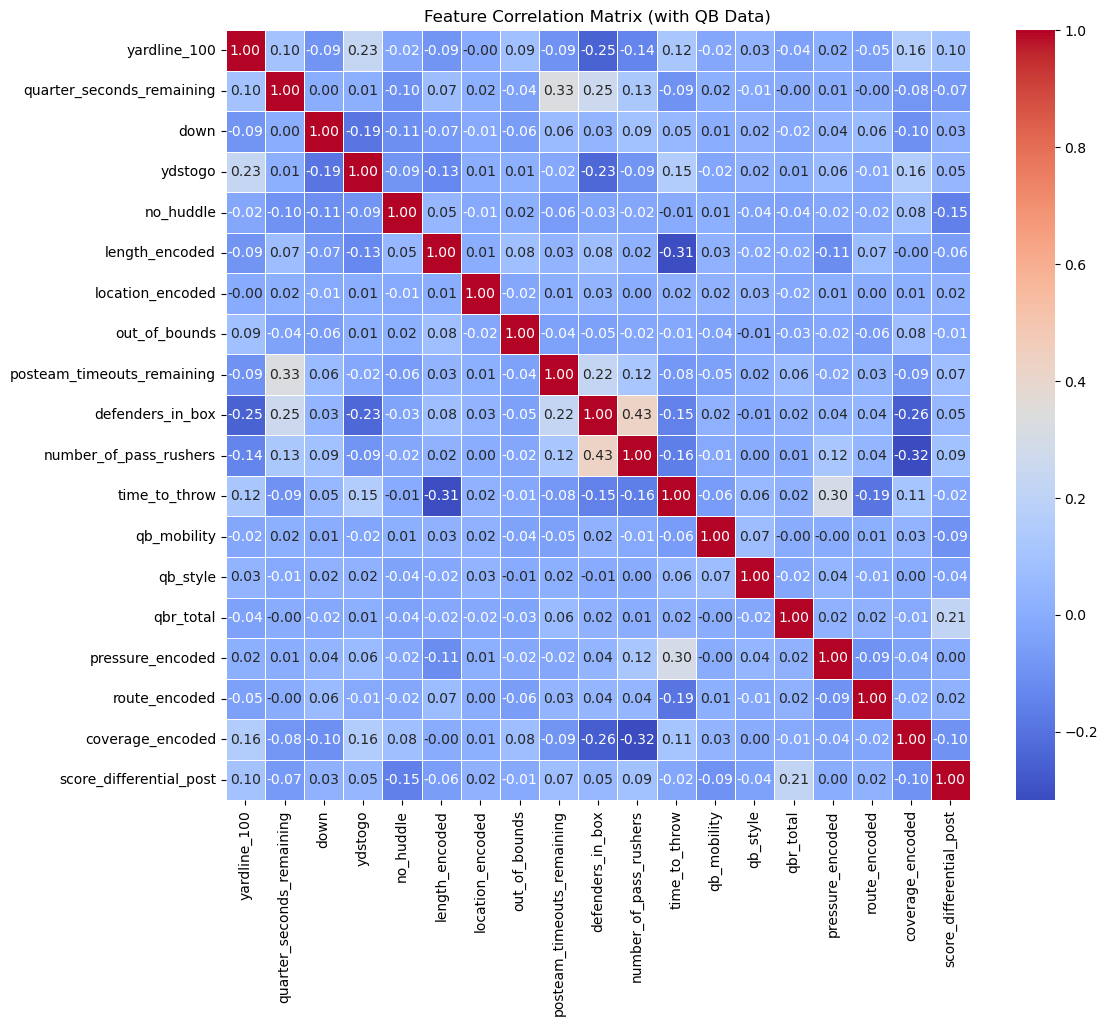

In [11]:
# CHeck for multicolinearity
corr_matrix = X.corr()

# Display the correlation matrix
print(corr_matrix)

# Plot the correlation heatmap for visual inspection
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Feature Correlation Matrix (with QB Data)")
plt.savefig('correlations/QB_correlations.png', bbox_inches='tight')
plt.show()

# This suggests weak to no multicolinearity between QB clustering features and pass-related features 
# (e.g. qb_style and time_to_throw)

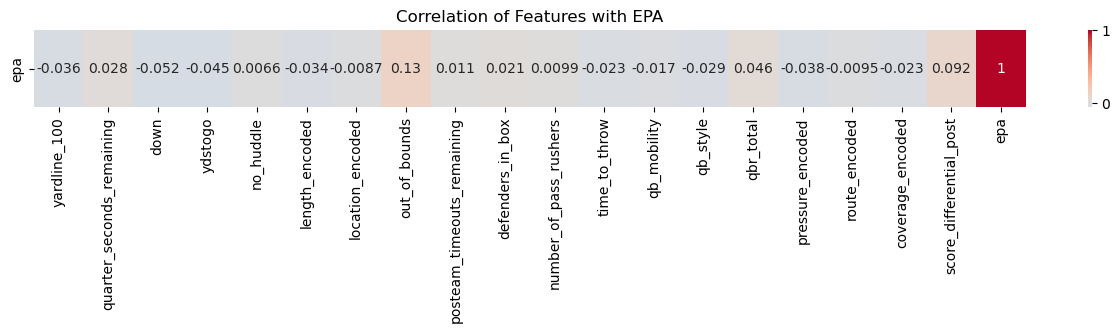

In [78]:
corr_epa = df[['yardline_100', 'quarter_seconds_remaining', 'down', 'ydstogo', 'no_huddle', 'length_encoded', 
                  'location_encoded', 'out_of_bounds', 'posteam_timeouts_remaining', 'defenders_in_box', 
                  'number_of_pass_rushers', 'time_to_throw',  'qb_mobility', 'qb_style', 'qbr_total', 
                  'pressure_encoded', 'route_encoded', 'coverage_encoded', 'score_differential_post', 'epa']]

corr_matrix_epa = corr_epa.corr()

correlation_with_epa = corr_matrix_epa[['epa']]

# Create the heatmap for correlation with the target
plt.figure(figsize=(16, 1))  # Adjust the size of the plot for readability
sns.heatmap(correlation_with_epa.T, annot=True, cmap='coolwarm', center=0, cbar=True)
plt.savefig('correlations/epa_correlations.png', bbox_inches='tight')
plt.title('Correlation of Features with EPA')
plt.show()

In [62]:
# Check variance of each feature
variance = X.var()
print(variance)

yardline_100                   558.483961
quarter_seconds_remaining     1254.846803
down                             0.914052
ydstogo                         16.295801
no_huddle                        0.172345
length_encoded                   0.180855
location_encoded                 0.726690
out_of_bounds                    0.135802
posteam_timeouts_remaining       1.227096
defenders_in_box                 1.162593
number_of_pass_rushers           0.621725
time_to_throw                    0.998025
qb_mobility                      1.157840
qb_style                         3.968593
qbr_total                      156.978318
pressure_encoded                 0.224304
route_encoded                    7.296963
coverage_encoded                 2.924746
score_differential_post         67.686448
dtype: float64


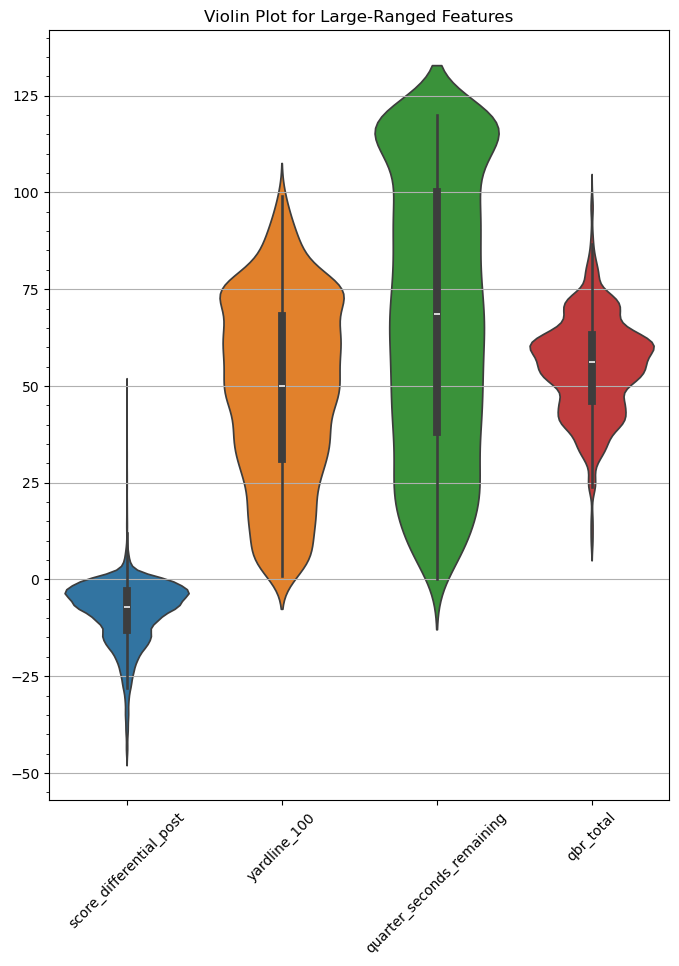

In [129]:
# Violinplots for large-ranged features (i.e. yardline_100 to qtr_seconds_remaining, qbr_total)
# Set the figure size for the plot
plt.figure(figsize=(8, 10))

# Create a violin plot for all features
sns.violinplot(data=X[['score_differential_post', 'yardline_100', 'quarter_seconds_remaining', 
                       'qbr_total']])

# Make it a grid for readability and add minor ticks
plt.grid(True)
plt.gca().tick_params(axis='x', which='minor', bottom=False)
plt.grid(axis = 'x')
plt.minorticks_on()


# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a title
plt.title('Violin Plot for Large-Ranged Features')

# Save output
plt.savefig('variance/lg_range_var.png', bbox_inches='tight')

# Show the plot
plt.show()

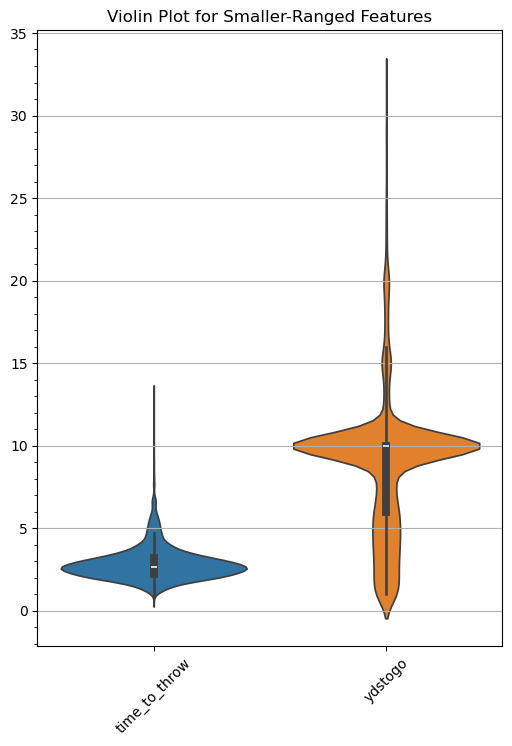

In [130]:
# Create violinplot for numerical features with smaller ranges

# Set the figure size for the plot
plt.figure(figsize=(6, 8))

# Create a violin plot for less extreme ranges 
sns.violinplot(data=X[['time_to_throw', 'ydstogo']])

# Make it a grid with minor ticks for readability
plt.grid(True)
plt.gca().tick_params(axis='x', which='minor', bottom=False)
plt.grid(axis = 'x')
plt.minorticks_on()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a title
plt.title('Violin Plot for Smaller-Ranged Features')

plt.savefig('variance/small_range_var.png', bbox_inches='tight')

# Show the plot
plt.show()


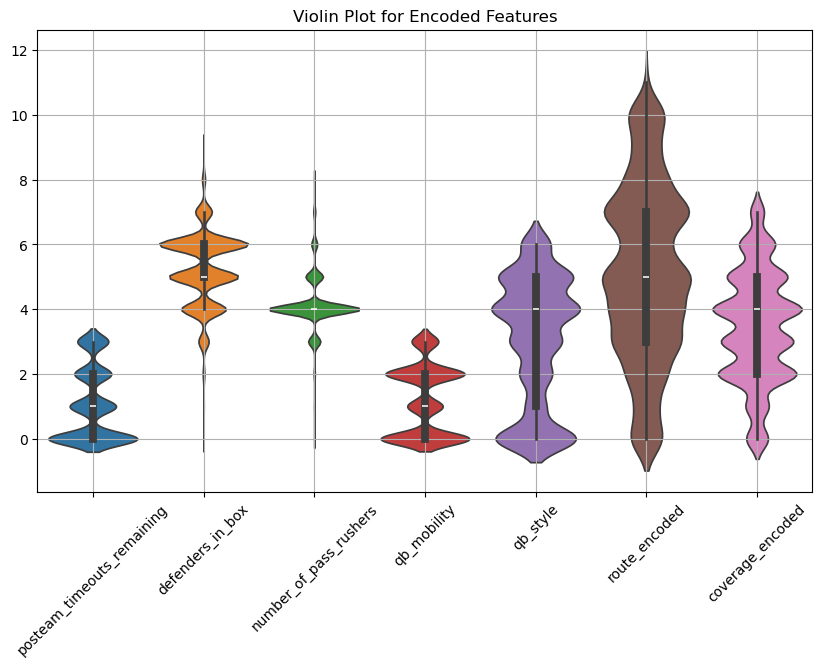

In [131]:
# Create violinplot of encoded features variance
# Set the figure size for the plot
plt.figure(figsize=(10, 6))

# Features that are categories with levels (or can be treated as such)
sns.violinplot(data=X[['posteam_timeouts_remaining', 'defenders_in_box', 'number_of_pass_rushers', 
                       'qb_mobility', 'qb_style', 'route_encoded', 'coverage_encoded']])

# Make it a grid with minor ticks for readability
plt.grid(True)


# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a title
plt.title('Violin Plot for Encoded Features')

plt.savefig('variance/encoded_var.png', bbox_inches='tight')

# Show the plot
plt.show()

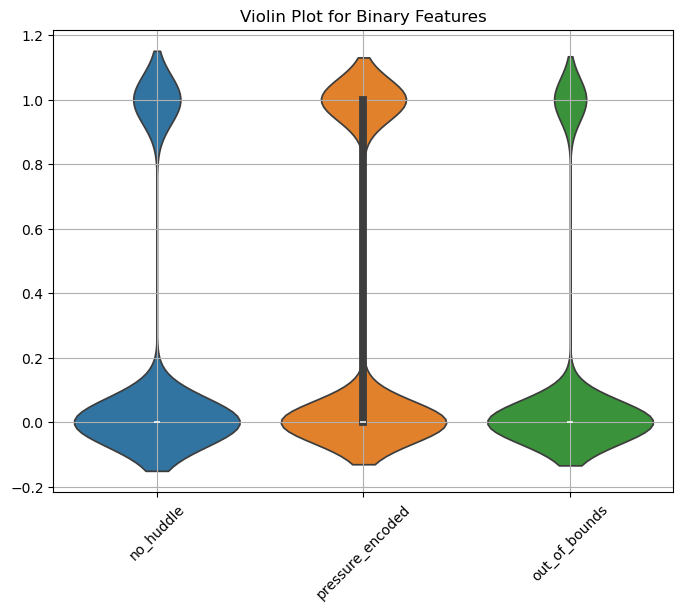

In [132]:
# Create violinplot of encoded binary features variance
# Create violinplot of encoded features variance
# Set the figure size for the plot
plt.figure(figsize=(8, 6))

# Features that are categories with levels (or can be treated as such)
sns.violinplot(data=X[['no_huddle', 'pressure_encoded', 'out_of_bounds', 'pressure_encoded']])

# Make it a grid for readability
plt.grid(True)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a title
plt.title('Violin Plot for Binary Features')

plt.savefig('variance/binary_var.png', bbox_inches='tight')

# Show the plot
plt.show()

                            yardline_100  quarter_seconds_remaining      down  \
yardline_100                  558.483961                  80.390285 -2.045642   
quarter_seconds_remaining      80.390285                1254.846803  0.127111   
down                           -2.045642                   0.127111  0.914052   
ydstogo                        21.898100                   2.098351 -0.744346   
no_huddle                      -0.215265                  -1.407079 -0.043132   
length_encoded                 -0.911313                   1.065013 -0.027071   
location_encoded               -0.084488                   0.491866 -0.008448   
out_of_bounds                   0.756798                  -0.470364 -0.020719   
posteam_timeouts_remaining     -2.408099                  12.979885  0.067124   
defenders_in_box               -6.340170                   9.734942  0.035418   
number_of_pass_rushers         -2.580189                   3.555659  0.070439   
time_to_throw               

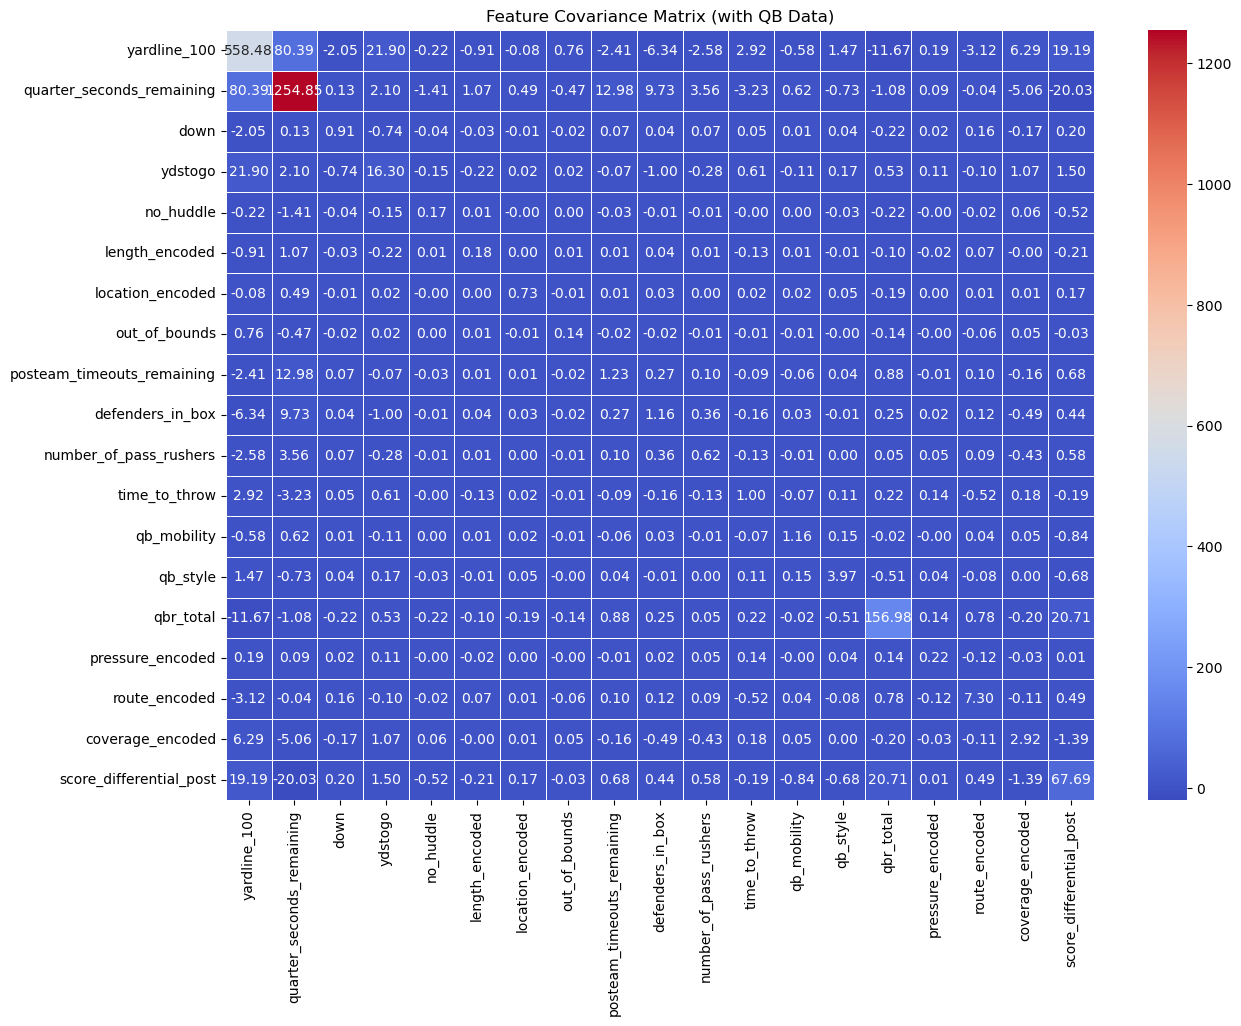

In [75]:
# Check for covariance

# Calculate the covariance matrix
cov_matrix = X.cov()

# Display the covariance matrix
print(cov_matrix)

# Plot the correlation heatmap for visual inspection
plt.figure(figsize=(14, 10))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Feature Covariance Matrix (with QB Data)")
plt.savefig('variance/QB_covariance.png', bbox_inches='tight')
plt.show()

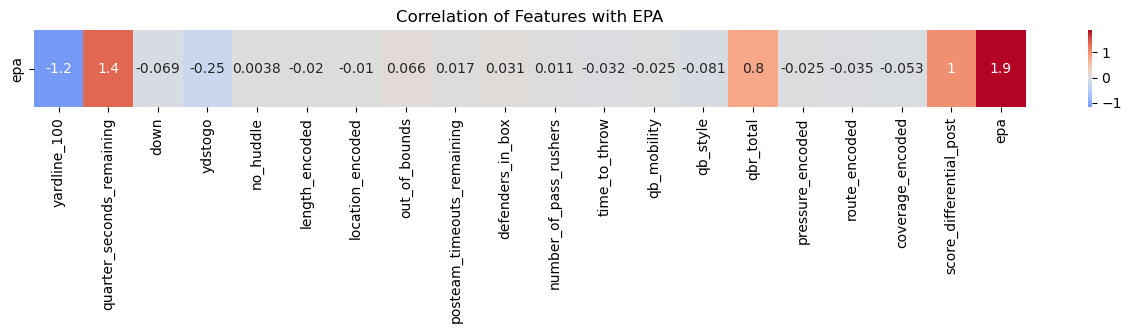

In [77]:
# Covariance with EPA

corr_epa = df[['yardline_100', 'quarter_seconds_remaining', 'down', 'ydstogo', 'no_huddle', 'length_encoded', 
                  'location_encoded', 'out_of_bounds', 'posteam_timeouts_remaining', 'defenders_in_box', 
                  'number_of_pass_rushers', 'time_to_throw', 'qb_mobility', 'qb_style', 'qbr_total', 
                  'pressure_encoded', 'route_encoded', 'coverage_encoded', 'score_differential_post', 'epa']]

cov_matrix_epa = corr_epa.cov()

covariance_with_epa = cov_matrix_epa[['epa']]

# Create the heatmap for correlation with the target
plt.figure(figsize=(16, 1))  # Adjust the size of the plot for readability
sns.heatmap(covariance_with_epa.T, annot=True, cmap='coolwarm', center=0, cbar=True)
plt.savefig('variance/epa_covariance.png', bbox_inches='tight')
plt.title('Correlation of Features with EPA')
plt.show()

## Model Implementation

We may consider removing the following features:

This is due to the fact that the clusters like `qb_style` should account for them and exhibit multicollinearity.

In [12]:
# Feature selection

X_raw = df[['yardline_100', 'quarter_seconds_remaining', 'down', 'ydstogo', 'no_huddle', 'length_encoded', 
                  'location_encoded', 'out_of_bounds', 'posteam_timeouts_remaining', 'defenders_in_box', 
                  'number_of_pass_rushers', 'time_to_throw', 'qb_mobility', 'qb_style', 'qbr_total', 
                  'route_encoded', 'pressure_encoded', 'coverage_encoded', 'score_differential_post']]

X_removed = df[['yardline_100', 'quarter_seconds_remaining', 'down', 'ydstogo', 'no_huddle',
                  'out_of_bounds', 'posteam_timeouts_remaining', 'defenders_in_box', 
                  'number_of_pass_rushers', 'qb_mobility', 'qb_style', 'qbr_total', 
                  'route_encoded', 'coverage_encoded', 'score_differential_post']]

X_more_removed = df[['yardline_100', 'quarter_seconds_remaining', 'down', 'ydstogo', 'no_huddle',
                  'out_of_bounds', 'posteam_timeouts_remaining',  
                  'qb_mobility', 'qb_style', 'qbr_total', 
                  'route_encoded', 'coverage_encoded', 'score_differential_post']]

# Set what X you would like to use for the model
#X = X_raw
X = X_removed
#X = X_more_removed // this was by far the worst model with MSE of 1.156 and R^2 of 0.16

y = df[['epa']]


In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, = train_test_split(
    X, y, test_size=0.2, random_state=97)

# Initialize model to tune
model_epa_basic = xgb.XGBRegressor(objective="reg:squarederror", random_state=97)

# Define the parameter grid
param_dist = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}


In [227]:
# Use RandomizedSearchCV to explore hyperparameter space
random_search = RandomizedSearchCV(estimator=model_epa_basic, param_distributions=param_dist, 
                                   n_iter=100, scoring='neg_mean_squared_error', cv=5, random_state=97)

random_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", random_search.best_params_)

# In case you don't want to execute the search, the results were the following:
# Before removing feautes: {'subsample': 0.9, 'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
# After removing features: {'subsample': 0.9, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
# More removed features: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.7}

KeyboardInterrupt: 

In [14]:
# Train XGBoost regression model to predict EPA based on tuned paramters

#best_params = random_search.best_params_

# or if you didn't run the search:

#best_params = {'subsample': 0.9, 'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.8} # Raw data
best_params = {'subsample': 0.9, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0} # Removed data
#best_params = {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.7} # More removed

model_epa = xgb.XGBRegressor(objective="reg:squarederror", **best_params)

model_epa.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Model Evaluation

In [15]:
# Make predictions based on testing data

y_pred = model_epa.predict(X_test)


In [16]:
# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)

# Calculate MSE (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)

# Calculate RMSE (Root Mean Squared Error)
rmse = math.sqrt(mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Display the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 0.8079534990928662
Mean Squared Error (MSE): 1.5545680378619073
Root Mean Squared Error (RMSE): 1.2468231782662316
R-squared (R²): 0.1626709218767396


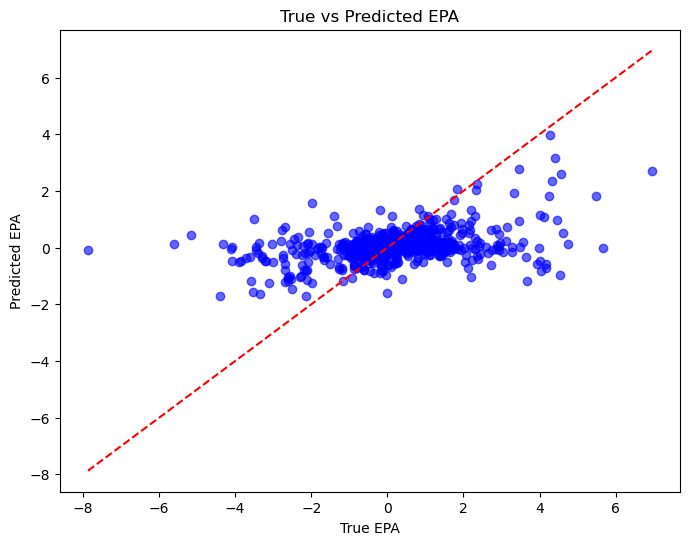

In [17]:
# Visualize Model
# Plot true vs predicted EPA values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Line of perfect prediction
plt.title('True vs Predicted EPA')
plt.xlabel('True EPA')
plt.ylabel('Predicted EPA')
plt.show()

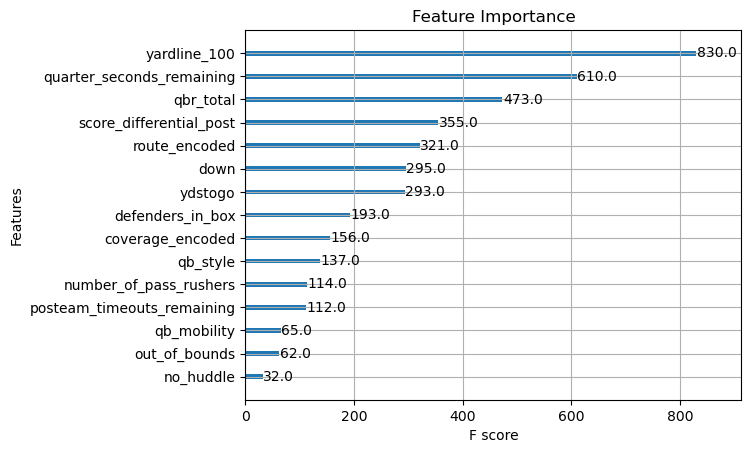

In [18]:
# Plot feature importances
xgb.plot_importance(model_epa, importance_type='weight')
plt.title('Feature Importance')
plt.savefig('qb_feature_importance.png', bbox_inches='tight')
plt.show()

In [100]:
# Compare against baseline (i.e. average)

# Compute the mean of the target variable (should we use median?)
y_mean = y.mean()

# Create baseline predictions (all predictions will be the mean)
y_pred_baseline = pd.Series([y_mean] * len(y), index=y.index)

# Evaluate the baseline model using MSE, MAE, and R-squared
mse_baseline = mean_squared_error(y, y_pred_baseline)
mae_baseline = mean_absolute_error(y, y_pred_baseline)
r2_baseline = r2_score(y, y_pred_baseline)

print(f'Mean Squared Error (MSE) for Baseline Model: {mse_baseline}')
print(f'Mean Absolute Error (MAE) for Baseline Model: {mae_baseline}')
print(f'R-squared for Baseline Model: {r2_baseline}')

Mean Squared Error (MSE) for Baseline Model: 1.884635877491998
Mean Absolute Error (MAE) for Baseline Model: 0.9040907176090964
R-squared for Baseline Model: 0.0


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/utils/_array_api.py:521: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/utils/_array_api.py:521: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/utils/_array_api.py:521: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)


In [99]:
# Compute the median of the target variable
y_median = y.median()

# Create baseline predictions (all predictions will be the median)
y_pred_baseline_median = pd.Series([y_median] * len(y), index=y.index)

# Evaluate the baseline model using MSE, MAE, and R-squared
mse_baseline_median = mean_squared_error(y, y_pred_baseline_median)
mae_baseline_median = mean_absolute_error(y, y_pred_baseline_median)
r2_baseline_median = r2_score(y, y_pred_baseline_median)

print(f'Mean Squared Error (MSE) for Baseline Model (Median): {mse_baseline_median}')
print(f'Mean Absolute Error (MAE) for Baseline Model (Median): {mae_baseline_median}')
print(f'R-squared for Baseline Model (Median): {r2_baseline_median}')


Mean Squared Error (MSE) for Baseline Model (Median): 1.9078537747538804
Mean Absolute Error (MAE) for Baseline Model (Median): 0.8916796740017672
R-squared for Baseline Model (Median): -0.012319566627787992


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/utils/_array_api.py:521: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/utils/_array_api.py:521: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/utils/_array_api.py:521: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)


## Prediction Test

In [20]:
# Get coverages
coverages = data[x]['defense_coverage_type'].unique()
print(coverages)

['COVER_3' 'COVER_4' 'COVER_1' 'COVER_0' 'COVER_6' 'COVER_2' '2_MAN'
 'PREVENT']


In [74]:
# Hold this context constant

context = {
    'yardline_100' : 75,
    'quarter_seconds_remaining': 120,
    'down': 1,
    'ydstogo': 10,
    'no_huddle': 0,
    #length_encoded': predict_length,
    #'location_encoded': predict_location,
    'out_of_bounds': 1,
    'posteam_timeouts_remaining': 3,
    'defenders_in_box': 6, 
    'number_of_pass_rushers': 4,
    #'time_to_throw': 2.1,
    'qb_mobility': 2, 
    'qb_style': 3, 
    'qbr_total': 65,
    #'pressure_encoded': False,
    'route_encoded': predict_route,
}

columns_to_min = ['yardline_100', 'quarter_seconds_remaining', 'down', 'ydstogo', 'no_huddle', 
    'out_of_bounds', 'posteam_timeouts_remaining', 'qb_mobility', 'qb_style', 'qbr_total', 'route_encoded',
                   'number_of_pass_rushers', 'defenders_in_box',]

In [72]:
# encode test features

predict_route = le_route.transform(['OUT'])[0]
predict_pressure = le_pressure.transform([False])[0]
predict_length = le_length.transform(['deep'])[0]
predict_location = le_location.transform(['left'])[0]


In [73]:
# Create dataframe to predict on

#X = df[['yardline_100', 'quarter_seconds_remaining', 'ydstogo', 'no_huddle', 'pass_length', 'pass_location', 'air_yards', 'out_of_bounds',
#        'defenders_in_box', 'number_of_pass_rushers', 'time_to_throw', 'was_pressure', 'route', 'defense_coverage_type']]

predict_data = pd.DataFrame()


for x in coverages:
    new_row = {
        **context,
        'coverage_encoded': le_coverage.transform([[x]]),
        'score_differential_post': -3
    }
    new_data = pd.DataFrame(new_row, index = [0])
    predict_data = pd.concat([predict_data, new_data])

    

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.

In [23]:
# Create predictions
predicted_epa = model_epa.predict(predict_data)

# Add the predictions to the DataFrame
predict_data['coverage_type'] = le_coverage.inverse_transform(predict_data['coverage_encoded'])
predict_data['predicted_EPA'] = predicted_epa

# Print results
print(predict_data[['coverage_type', 'predicted_EPA']].sort_values(by=['predicted_EPA']))

  coverage_type  predicted_EPA
0       COVER_1       0.401023
0       COVER_0       0.438300
0       PREVENT       0.449026
0       COVER_3       0.450874
0       COVER_2       0.450874
0       COVER_4       0.467274
0       COVER_6       0.467274
0         2_MAN       0.545147


## Optimization

Use optimization techniques in order to find the optimal number of pass rushers and defenders in the box in order to minimize EPA. 

In [93]:
# New context to predict features when minimizing EPA
# Let initial guess of pass rushers and defenders in box be median 

context_to_min = {
    'yardline_100' : 75,
    'quarter_seconds_remaining': 120,
    'down': 1,
    'ydstogo': 10,
    'no_huddle': 0,
    #length_encoded': predict_length,
    #'location_encoded': predict_location,
    'out_of_bounds': 1,
    'posteam_timeouts_remaining': 3,
    #'time_to_throw': 2.1,
    'qb_mobility': 2, 
    'qb_style': 3, 
    'qbr_total': 65,
    #'pressure_encoded': False,
    'route_encoded': predict_route,
    'score_differential_post': -3
}

min_context_data = ['yardline_100', 'quarter_seconds_remaining', 'down', 'ydstogo', 'no_huddle', 
                    'out_of_bounds', 'posteam_timeouts_remaining', 'defenders_in_box', 'number_of_pass_rushers', 
                    'qb_mobility', 'qb_style', 'qbr_total', 'route_encoded', 'coverage_encoded', 'score_differential_post']

# Base this on median number of pass rushers and defenders in box
initial_guess = [4, 5, 5]

In [94]:
# Create objective function that minimizes EPA based on context

def objective_function(params):
    number_of_pass_rushers, defenders_in_box, coverage_encoded = params

    strategy = {**context_to_min, 
                'number_of_pass_rushers': number_of_pass_rushers, 
                'defenders_in_box': defenders_in_box,
                'coverage_encoded': coverage_encoded}

    # Convert the strategy dictionary into a DataFrame for model prediction
    strategy_df = pd.DataFrame([strategy], columns=min_context_data)

    return model_epa.predict(strategy_df)[0]

In [95]:
# Use the minimize function to predict optimal strategy given context

result = minimize(objective_function, initial_guess, bounds=[(0, 8), (0, 9), (0, 8)])
print(f"Optimial strategy", result.x)
print("Expected minimized EPA:", result.fun)

# For some reason this doesn't actually deviate from the initial guess, I'm not sure where the error is.
# It could just be that these features don't affect EPA very much based on the model. However, coverage
# should theorhetically create a substantial difference, so that should've been changed at least.

Optimial strategy [4. 5. 5.]
Expected minimized EPA: 0.4672742


## Analysis

Adding the QB quality clusters to the original list of features actually degraded the model slightly, as $MSE$ increased to $1.520$ EPA and $R^2$ decreased to $0.183$. I then removed some features to see if this would make any adjustments.

After removing the features {`time_to_throw`, `pressure_encoded`, `length`, `location`}, the tests yielded $MSE \approx 1.555$ and $R^2 \approx 0.163$, suggesting that while removing dimeonsionality and complexity did not help. However, the clusterings can adequately account for the removed features. I believe this is ultimately beneficial, as these features can be difficult to predict on a play-by-play basis (particularly `time_to_throw`). I think we could sacrifice accuracy for simplicity.

In all cases, the model performed better than the baselines using mean and median. Those results yielded $MSE \approx 1.885$ and $R^2 = 0$, as well as $MSE \approx 1.908$ and $R^2 \approx -0.012$ respectively. Consequently, I think this model should be used instead of calculating averages.

### Possible Improvements
- Modify QB clustering model
- See which features not related to QB clustering should be removed

Regarding QB clustering, there are several changes I'd like to make. In addition to passing depth, I'd like to account location (e.g. left, middle, right) when clustering QB playstyle. I'd also like to reduce the number of levels in the `qb_style` cluster.

I think removing `time_to_throw` helps reduce complexity and dimensionality to the model, as it can be very difficult to predict on a play-by-play basis. However, I would like to account for it somehow. I think using a QB cluster's average `time_to_throw` based on their playstyle would be more appropriate. 

I'm unsure if `number_of_pass_rushers` and `defenders_in_box` are particularly important features, and there could be significant covariance between those features and `qb_style`. For instance, based on a `qb_style`, would it be better to send more or less pass rushers? Should we send more blitzers against immobile QBs? How would this affect EPA, and will the model reflect such effects accurately?

Also, this also doesn't account for if QBs change playing styles in normal game situations vs two-minute drills (e.g. increasing or decreasing aggression). However, it is possible there isn't much variance between QB playstyles in situational football. We would have to explore that first before making changes based on conclusion.

### Summary

QB clustering did not directly improve the model's performance. However, because they reduce dimensionality and complexity of inputs, they should still be used. I believe it is worth sacrificing marginal accuracy for significantly greater simplicity.

I think QB clustering should be used to remove the features {`time_to_throw`, `pressure_encoded`, `length`, `location`}. These features can be difficult to predict, so we should instead use QB clustering to effectively predict and estimate these features based on the cluster's tendencies of their playstyle. For instance, instead of inputting a time to throw of 2.5 seconds, we should input a QB cluster to account for a QB who can find addition seconds to throw the ball, has a very fast release, or would get pressured (and maybe take a sack).